In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

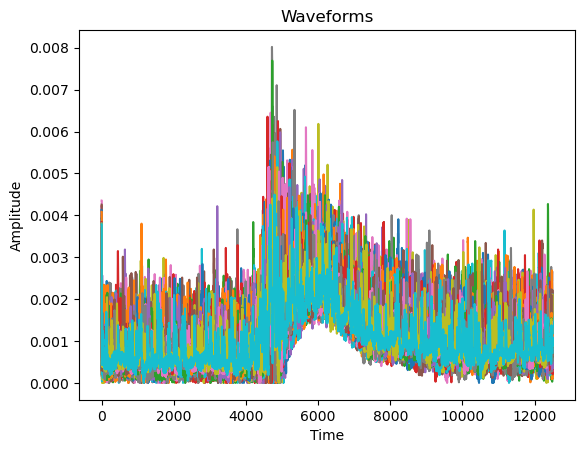

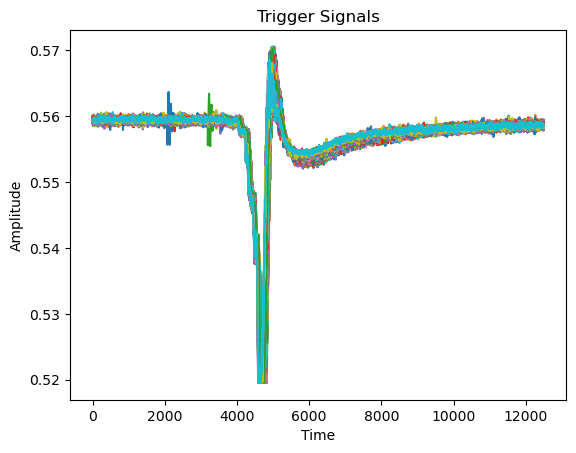

In [90]:
def read_data(filename, seg_len):
    filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]

    np.nan_to_num(waveforms[:,:,2], copy=False, nan=0)

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2]))
        plt.plot(waveform[:, 2])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveforms")
    #plt.xlim(5800,6400)
    plt.show()

    for waveform in waveforms:
        plt.plot(waveform[:, 1])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Trigger Signals")
    #plt.xlim(5800,6400)
    plt.show()

    return waveforms, n_segs

waveforms, n_segs = read_data("1000V_Ar_VUV_SiPM (06,12,2024).csv", 12500)

12500


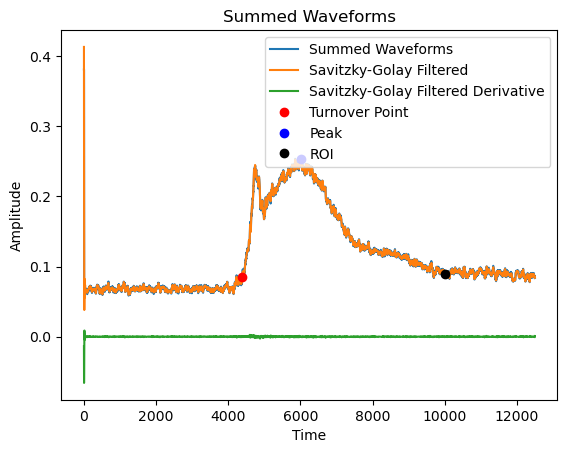

In [82]:
def find_roi(waveforms, n_segs, plot=False):

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2]))

    if plot==True:
        for i in range(n_segs):
            plt.plot(waveforms[i,:,2])
            plt.show()

    waveforms_sum = np.sum(waveforms, axis=0)
    savgol_filtered = savgol_filter(waveforms_sum[:, 2], 60, 9)
    savgol_filtered_deriv = savgol_filter(waveforms_sum[:, 2], 60, 9, deriv=1)

    print(len(savgol_filtered))

    turnover_point = np.argmin(np.abs(savgol_filtered_deriv[np.argmin(savgol_filtered_deriv):np.argmax(savgol_filtered_deriv)])) + np.argmin(savgol_filtered_deriv[500:])
    peak = np.argmax(savgol_filtered[500:])
    roi = [turnover_point, peak+4*(peak-turnover_point)]

    plt.plot(waveforms_sum[:, 2], label="Summed Waveforms")
    plt.plot(savgol_filtered, label="Savitzky-Golay Filtered")
    plt.plot(savgol_filtered_deriv, label="Savitzky-Golay Filtered Derivative")
    plt.plot(turnover_point, savgol_filtered[turnover_point], 'ro', label="Turnover Point")
    plt.plot(peak+500, savgol_filtered[peak+500], 'bo', label="Peak")
    plt.plot(roi[1], savgol_filtered[roi[1]], 'ko', label="ROI")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Summed Waveforms")
    plt.legend()
    #plt.xlim(2000,12000)
    #plt.ylim(-0.01, 0.01)
    plt.show()

    return turnover_point, (peak+500)

start, peak = find_roi(waveforms, n_segs, plot=False)

fit nth order polynomial to each waveform and integrate between trough and 10% of peak

In [83]:
from scipy.stats import skewnorm
from scipy.special import erfc
from scipy.integrate import quad

def skewed_gaussian(x, A, mean, sigma, alpha):
    return A * skewnorm.pdf(x, alpha, loc=mean, scale=sigma)

def emg(x, A, mu, sigma, tau):
    """Exponentially Modified Gaussian"""
    z = (x - mu) / sigma
    return A * (tau / 2) * np.exp((sigma ** 2) / (2 * tau ** 2) - z / tau) * erfc((sigma / np.sqrt(2) * tau) - (z / np.sqrt(2)))

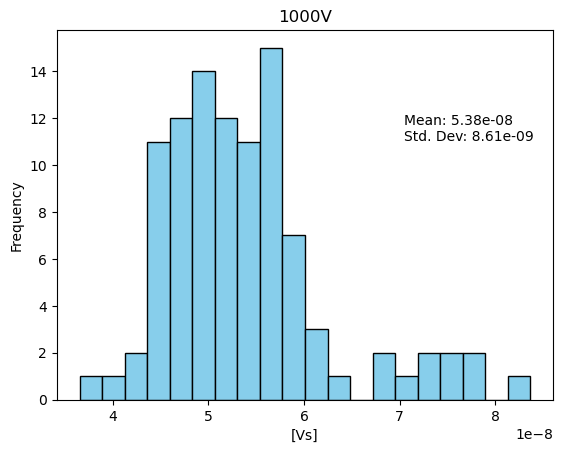

[4.634621968901785e-08,
 4.4493637311879604e-08,
 5.065980266664966e-08,
 5.302474103922932e-08,
 6.190193341331889e-08,
 4.403661424691366e-08,
 4.612844742162917e-08,
 4.499078762738221e-08,
 5.637462135207183e-08,
 5.6550608105927726e-08,
 7.342635338413406e-08,
 5.700764921665928e-08,
 5.878659586950746e-08,
 4.882265914051939e-08,
 5.689457892765651e-08,
 5.091253382584256e-08,
 5.19490327434846e-08,
 6.37132377427706e-08,
 5.831384230317186e-08,
 4.6092591536478184e-08,
 4.5547463227078716e-08,
 4.499649028655971e-08,
 5.657280633674853e-08,
 4.9418439585781944e-08,
 4.719937400696846e-08,
 4.377700626552827e-08,
 8.370740169105257e-08,
 5.476889038946584e-08,
 5.54213855275186e-08,
 5.7905187728575884e-08,
 5.715255018428419e-08,
 5.558627529840777e-08,
 5.68221340213297e-08,
 5.632732064455284e-08,
 5.926934821252923e-08,
 5.888325641625347e-08,
 4.7093250374177715e-08,
 7.557819381873187e-08,
 4.938014785836586e-08,
 4.571409154037393e-08,
 4.747969058787757e-08,
 4.9183932802

In [106]:
def integrate(waveforms, n_segs, start):
    areas = []  # Store the area for each waveform

    for i in range(n_segs):
        # Extract x and y data for the current waveform
        x_data = waveforms[i, :, 0]
        y_data = waveforms[i, :, 2]

        # Initial guesses for the EMG fit
        initial_guess = [1.003, x_data[np.argmax(y_data)], 1e-5, 1]

        # Fit the EMG model
        params, _ = curve_fit(emg, x_data, y_data, p0=initial_guess, maxfev=10000)

        # Integrate the EMG model over the range of x_data
        area, _ = quad(emg, x_data[0], x_data[-1], args=tuple(params))
        areas.append(area)

        # Optional: Plot individual fits (uncomment for debugging)
        # fitted_peak = emg(x_data, *params)
        # plt.plot(x_data, y_data, '.', label="Noisy Data")
        # plt.plot(x_data, fitted_peak, label="Fitted EMG", linewidth=2)
        # plt.legend()
        # plt.show()
    
    mean = np.mean(areas)
    std_dev = np.std(areas)

    # Plot a histogram of the areas
    plt.hist(areas, bins=20, color='skyblue', edgecolor='black')
    plt.title("1000V")
    plt.xlabel("[Vs]")
    plt.ylabel("Frequency")
    plt.annotate(f"Mean: {mean:.2e}\nStd. Dev: {std_dev:.2e}", xy=(0.7, 0.7), xycoords='axes fraction')
    plt.show()

    return areas

integrate(waveforms, n_segs, start)

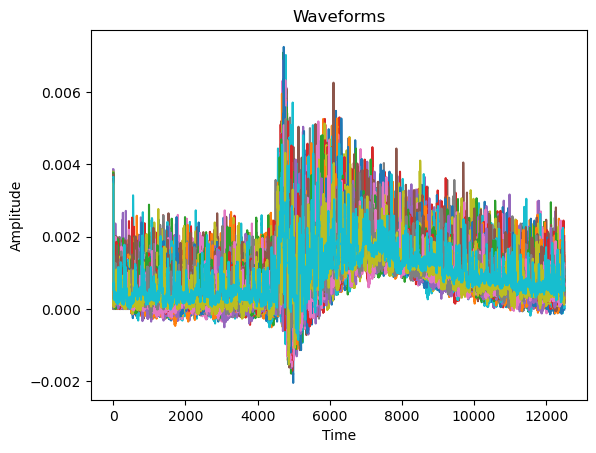

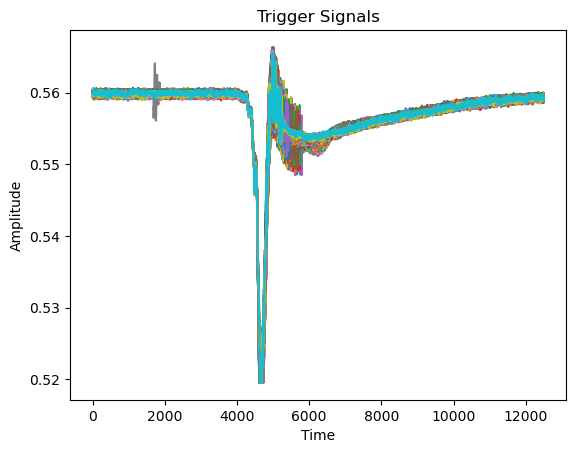

In [94]:
def read_data(filename, seg_len):
    filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]

    np.nan_to_num(waveforms[:,:,2], copy=False, nan=0)

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2][0:500]))
        plt.plot(waveform[:, 2])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveforms")
    #plt.xlim(5800,6400)
    plt.show()

    for waveform in waveforms:
        plt.plot(waveform[:, 1])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Trigger Signals")
    #plt.xlim(5800,6400)
    plt.show()

    return waveforms, n_segs

waveforms1100, n_segs1100 = read_data("1100V_Ar_VUV_SiPM (06,12,2024).csv", 12500)

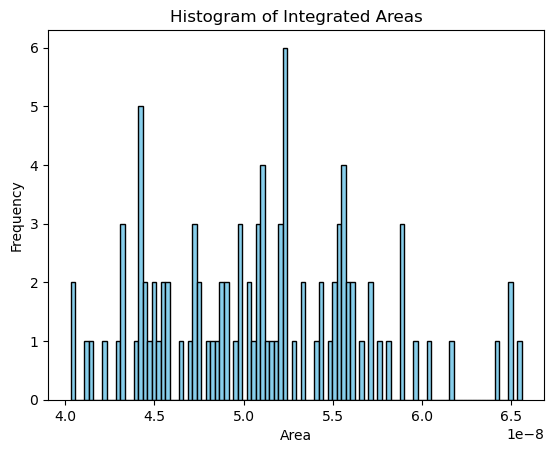

[5.23491510876755e-08,
 5.2143223533538285e-08,
 5.663527664869885e-08,
 4.494341686042003e-08,
 5.616606304148776e-08,
 4.1244592077906986e-08,
 4.433750567081666e-08,
 5.724168626150793e-08,
 4.454893721392117e-08,
 5.520110912815035e-08,
 5.106993103398875e-08,
 5.163246755496128e-08,
 5.439212899766893e-08,
 4.7193799448198284e-08,
 4.3342575872331174e-08,
 4.87028563952406e-08,
 4.4224278508432945e-08,
 4.947346902322896e-08,
 5.221024306279744e-08,
 4.558154732644078e-08,
 5.035220623490535e-08,
 4.979119343262157e-08,
 4.9096825222479464e-08,
 4.885215620665605e-08,
 4.9910413200639484e-08,
 5.95581554261332e-08,
 4.691353455359305e-08,
 5.093767197028633e-08,
 5.337458617698512e-08,
 5.810435336268833e-08,
 4.3095031342871184e-08,
 5.11622953694168e-08,
 5.325252576633214e-08,
 4.582362852831326e-08,
 4.8021871607207546e-08,
 5.243092409697322e-08,
 5.7199961511557535e-08,
 5.0234188451308126e-08,
 4.580476226769843e-08,
 4.4216516254555784e-08,
 5.105212089652964e-08,
 4.48385

In [105]:
def integrate(waveforms, n_segs):
    areas = []  # Store the area for each waveform

    for i in range(n_segs):
        # Extract x and y data for the current waveform
        x_data = waveforms[i, :, 0]
        y_data = waveforms[i, :, 2]

        # Initial guesses for the EMG fit
        initial_guess = [0.003, x_data[np.argmax(y_data)], 1e-5, 1]

        # Fit the EMG model
        params, _ = curve_fit(emg, x_data, y_data, p0=initial_guess, maxfev=20000)

        # Integrate the EMG model over the range of x_data
        area, _ = quad(emg, x_data[0], x_data[-1], args=tuple(params))
        areas.append(area)

        # Optional: Plot individual fits (uncomment for debugging)
        #fitted_peak = emg(x_data, *params)
        #plt.plot(x_data, y_data, '.', label="Noisy Data")
        #plt.plot(x_data, fitted_peak, label="Fitted EMG", linewidth=2)
        #plt.legend()
        #plt.show()

    # Plot a histogram of the areas
    plt.hist(areas, bins=100, color='skyblue', edgecolor='black')
    plt.title("Histogram of Integrated Areas")
    plt.xlabel("Area")
    plt.ylabel("Frequency")
    plt.show()

    return areas

integrate(waveforms1100, n_segs1100)

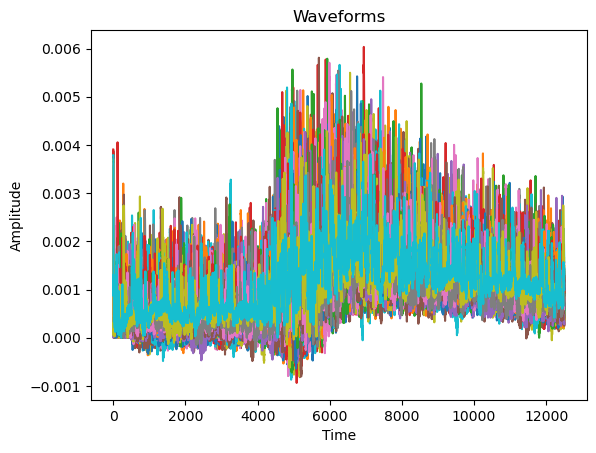

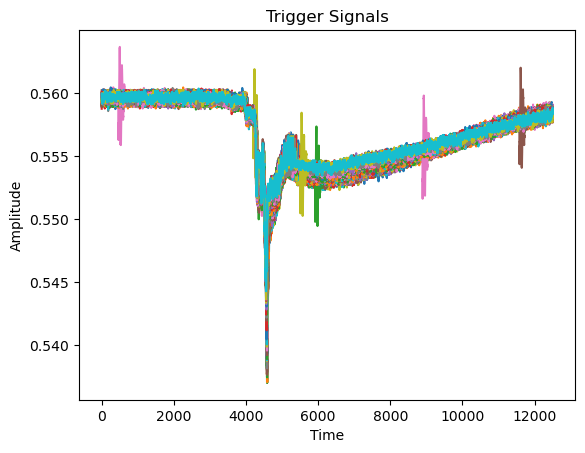

In [100]:
def read_data(filename, seg_len):
    filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]

    np.nan_to_num(waveforms[:,:,2], copy=False, nan=0)

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2][0:500]))
        plt.plot(waveform[:, 2])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveforms")
    #plt.xlim(5800,6400)
    plt.show()

    for waveform in waveforms:
        plt.plot(waveform[:, 1])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Trigger Signals")
    #plt.xlim(5800,6400)
    plt.show()

    return waveforms, n_segs

waveforms1200, n_segs1200 = read_data("1200V_Ar_VUV_SiPM (06,12,2024).csv", 12500)

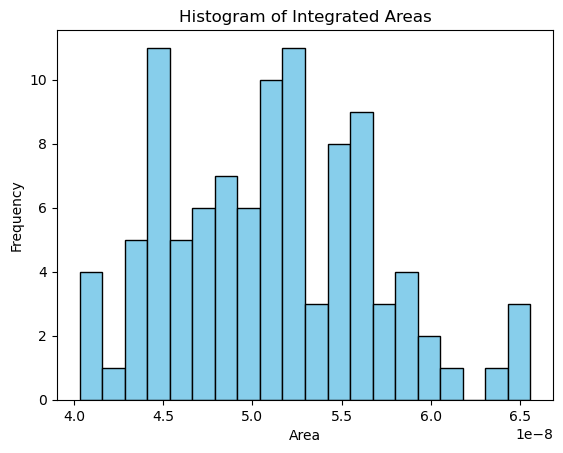

[5.23491510876755e-08,
 5.2143223533538285e-08,
 5.663527664869885e-08,
 4.494341686042003e-08,
 5.616606304148776e-08,
 4.1244592077906986e-08,
 4.433750567081666e-08,
 5.724168626150793e-08,
 4.454893721392117e-08,
 5.520110912815035e-08,
 5.106993103398875e-08,
 5.163246755496128e-08,
 5.439212899766893e-08,
 4.7193799448198284e-08,
 4.3342575872331174e-08,
 4.87028563952406e-08,
 4.4224278508432945e-08,
 4.947346902322896e-08,
 5.221024306279744e-08,
 4.558154732644078e-08,
 5.035220623490535e-08,
 4.979119343262157e-08,
 4.9096825222479464e-08,
 4.885215620665605e-08,
 4.9910413200639484e-08,
 5.95581554261332e-08,
 4.691353455359305e-08,
 5.093767197028633e-08,
 5.337458617698512e-08,
 5.810435336268833e-08,
 4.3095031342871184e-08,
 5.11622953694168e-08,
 5.325252576633214e-08,
 4.582362852831326e-08,
 4.8021871607207546e-08,
 5.243092409697322e-08,
 5.7199961511557535e-08,
 5.0234188451308126e-08,
 4.580476226769843e-08,
 4.4216516254555784e-08,
 5.105212089652964e-08,
 4.48385

In [ ]:
def integrate(waveforms, n_segs):
    areas = []  # Store the area for each waveform

    for i in range(n_segs):
        # Extract x and y data for the current waveform
        x_data = waveforms[i, :, 0]
        y_data = waveforms[i, :, 2]

        # Initial guesses for the EMG fit
        initial_guess = [0.003, x_data[np.argmax(y_data)], 1e-5, 1]

        # Fit the EMG model
        params, _ = curve_fit(emg, x_data, y_data, p0=initial_guess, maxfev=20000)

        # Integrate the EMG model over the range of x_data
        area, _ = quad(emg, x_data[0], x_data[-1], args=tuple(params))
        areas.append(area)

        # Optional: Plot individual fits (uncomment for debugging)
        #fitted_peak = emg(x_data, *params)
        #plt.plot(x_data, y_data, '.', label="Noisy Data")
        #plt.plot(x_data, fitted_peak, label="Fitted EMG", linewidth=2)
        #plt.legend()
        #plt.show()

    # Plot a histogram of the areas
    plt.hist(areas, bins=20, color='skyblue', edgecolor='black')
    plt.title("Histogram of Integrated Areas")
    plt.xlabel("Area")
    plt.ylabel("Frequency")
    plt.show()

    return areas

integrate(waveforms1200, n_segs1200)